In [1]:
from xmitgcm import open_mdsdataset
import xarray as xr
import numpy as np
import xgcm
import datetime
import os
from matplotlib import pyplot as plt 
from scipy import interpolate
import warnings; warnings.simplefilter('ignore')

from parcels import FieldSet, ParticleSet, Variable, JITParticle, AdvectionRK4, plotTrajectoriesFile, AdvectionRK4_3D, ErrorCode
import math
from datetime import timedelta
from operator import attrgetter

%matplotlib inline
plt.rcParams['figure.figsize'] = (15,10)
plt.rcParams['font.size'] = 16
plt.rcParams['text.usetex'] = False

from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:35229 Dashboard: http://127.0.0.1:35717/status,Cluster Workers: 9 Cores: 72 Memory: 134.72 GB


In [3]:
dst1 = xr.open_dataset('1DayParticles.nc')
dst5 = xr.open_dataset('5DayParticles.nc')
dst10 = xr.open_dataset('10DayParticles.nc')

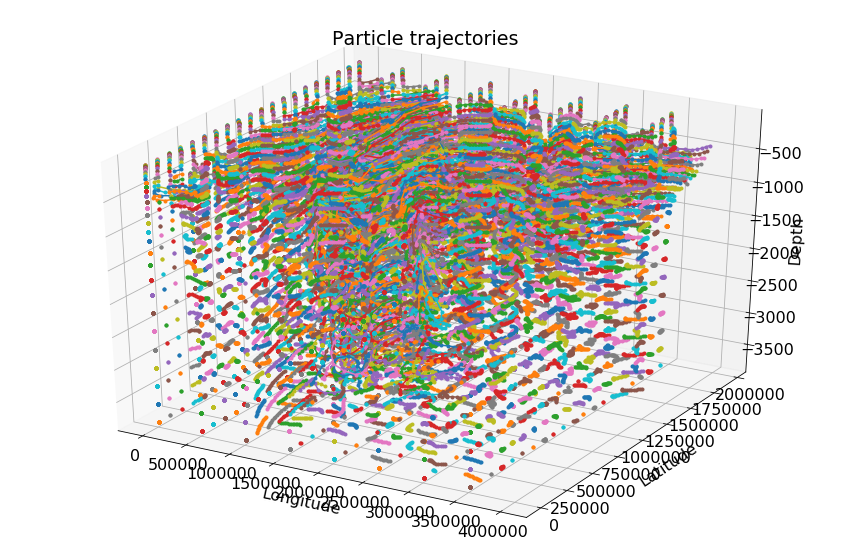

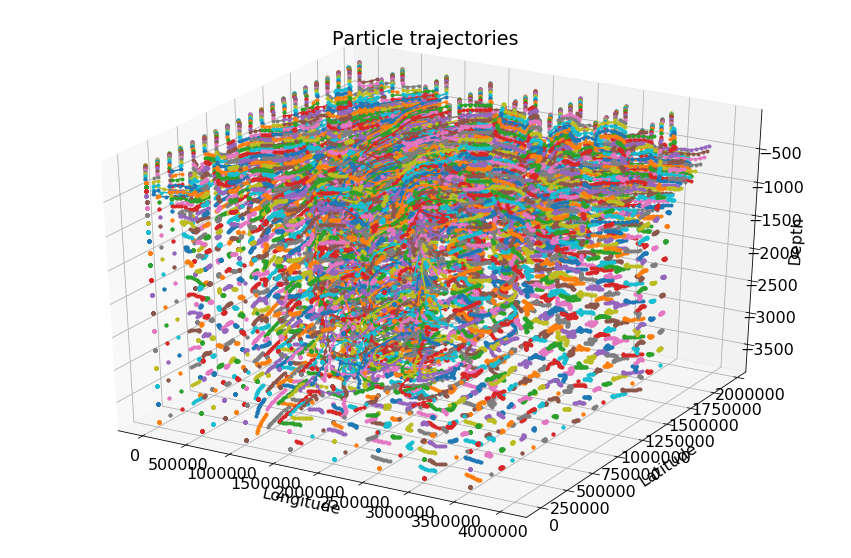

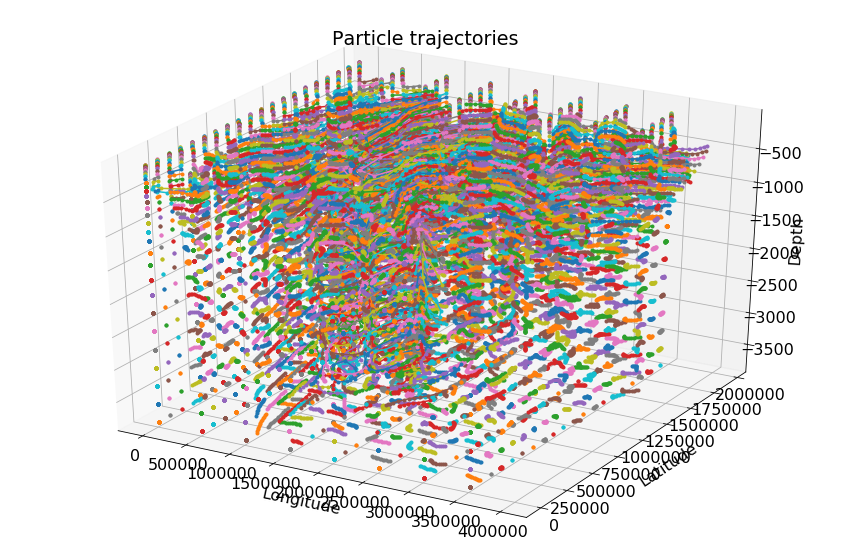

In [4]:
plotTrajectoriesFile('1DayParticles.nc',mode='3d');
plotTrajectoriesFile('5DayParticles.nc',mode='3d');
plotTrajectoriesFile('10DayParticles.nc',mode='3d');

## Calculate the deviation from the 1 day trajectories

(array([3.0407e+04, 4.5450e+03, 2.2090e+03, 1.3300e+03, 8.5800e+02,
        6.3500e+02, 4.9600e+02, 3.3900e+02, 2.7900e+02, 2.1400e+02,
        1.5800e+02, 1.4500e+02, 1.3600e+02, 1.1600e+02, 8.2000e+01,
        9.8000e+01, 8.2000e+01, 7.9000e+01, 8.3000e+01, 6.2000e+01,
        6.2000e+01, 5.0000e+01, 5.7000e+01, 4.6000e+01, 5.6000e+01,
        4.3000e+01, 4.1000e+01, 2.8000e+01, 3.4000e+01, 3.5000e+01,
        2.8000e+01, 3.1000e+01, 2.9000e+01, 2.4000e+01, 3.0000e+01,
        2.4000e+01, 2.8000e+01, 2.1000e+01, 2.2000e+01, 2.1000e+01,
        1.6000e+01, 1.4000e+01, 1.0000e+01, 2.1000e+01, 1.3000e+01,
        8.0000e+00, 1.4000e+01, 1.0000e+01, 1.6000e+01, 1.2000e+01,
        1.4000e+01, 9.0000e+00, 1.1000e+01, 1.0000e+01, 1.0000e+01,
        1.1000e+01, 1.3000e+01, 1.5000e+01, 4.0000e+00, 7.0000e+00,
        7.0000e+00, 5.0000e+00, 5.0000e+00, 5.0000e+00, 5.0000e+00,
        2.0000e+00, 4.0000e+00, 7.0000e+00, 5.0000e+00, 3.0000e+00,
        1.0000e+00, 3.0000e+00, 2.0000e+00, 3.00

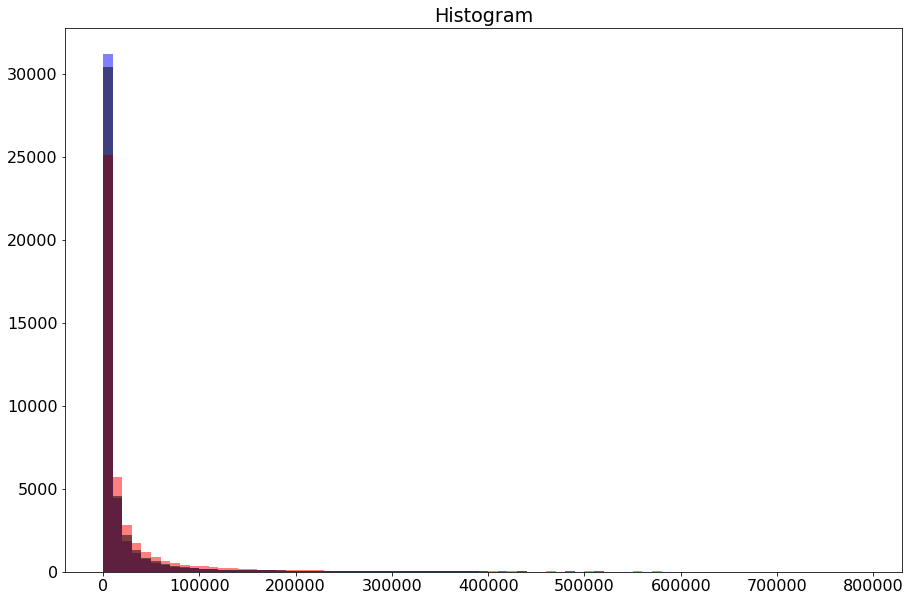

In [5]:
diff5 = xr.ufuncs.sqrt((dst5.lat - dst1.lat)*(dst5.lat - dst1.lat) + (dst5.lon - dst1.lon)*(dst5.lon - dst1.lon)) 
diff10 = xr.ufuncs.sqrt((dst10.lat - dst1.lat)*(dst10.lat - dst1.lat) + (dst10.lon - dst1.lon)*(dst10.lon - dst1.lon))
diff510 = xr.ufuncs.sqrt((dst10.lat - dst5.lat)*(dst10.lat - dst5.lat) + (dst10.lon - dst5.lon)*(dst10.lon - dst5.lon))

plt.figure()
diff5.plot.hist(bins=range(0,800000,10000),ls='dashed',fc=(0, 0, 1, 0.5))
diff10.plot.hist(bins=range(0,800000,10000),fc=(1, 0, 0, 0.5))
diff510.plot.hist(bins=range(0,800000,10000),fc=(0, 0, 0, 0.5))

(array([3.8366e+04, 2.3900e+03, 8.2500e+02, 4.2700e+02, 3.1300e+02,
        2.1900e+02, 1.8000e+02, 1.1700e+02, 1.1300e+02, 9.1000e+01,
        6.1000e+01, 5.2000e+01, 5.3000e+01, 4.1000e+01, 4.4000e+01,
        2.1000e+01, 1.7000e+01, 1.9000e+01, 9.0000e+00, 4.0000e+00,
        2.0000e+00, 1.0000e+00, 3.0000e+00, 0.0000e+00, 0.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([      0.  ,   38956.77,   77913.54,  116870.31,  155827.08,
         194783.86,  233740.62,  272697.4 ,  311654.16,  350610.94,
         389567.72,  428524.47,  467481.25,  506438.03,  545394.8 ,
         584351.56,  623308.3 ,  662265.1 ,  701221.9 ,  740178.6 ,
         779135.44,  818092.2 ,  857048.94,  896005.75,  934962.5 ,
         973919.25, 1012876.06, 1051832.8 , 1090789.6 , 1129746.4 ,
        1168703.1 ], dtype=float32),
 <a list of 30 Patch objects>)

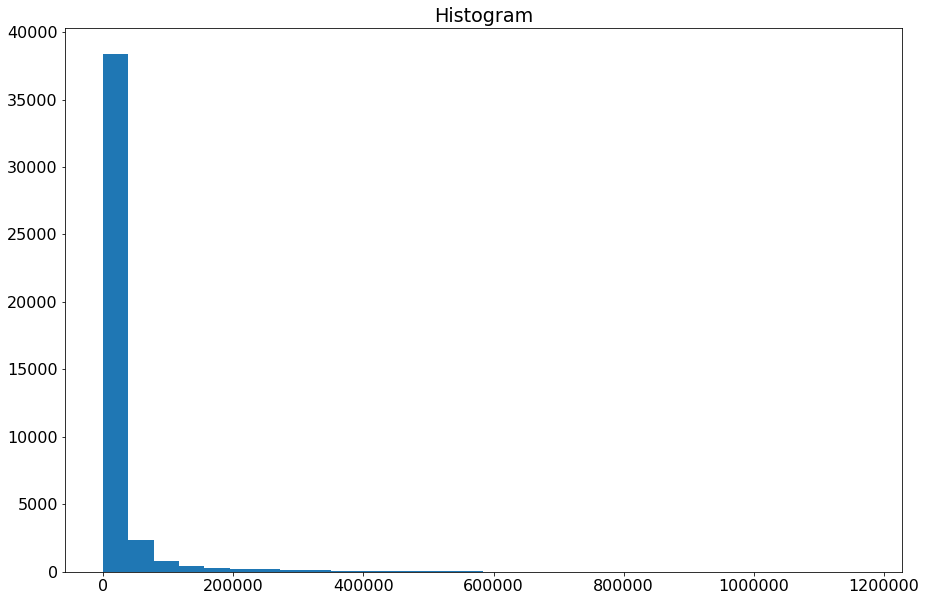

## Calculate the temperature spread along the particles for the different trajectories

(array([2.0000e+01, 2.5000e+01, 2.8000e+01, 4.3000e+01, 2.7000e+01,
        4.8000e+01, 5.4000e+01, 1.2000e+02, 1.8400e+02, 2.7400e+02,
        5.9500e+02, 1.6170e+03, 3.7505e+04, 2.0700e+03, 3.6500e+02,
        1.6400e+02, 9.3000e+01, 5.7000e+01, 4.7000e+01, 4.7000e+01,
        3.7000e+01, 2.6000e+01, 1.5000e+01, 1.0000e+01]),
 array([-0.625, -0.575, -0.525, -0.475, -0.425, -0.375, -0.325, -0.275,
        -0.225, -0.175, -0.125, -0.075, -0.025,  0.025,  0.075,  0.125,
         0.175,  0.225,  0.275,  0.325,  0.375,  0.425,  0.475,  0.525,
         0.575]),
 <a list of 24 Patch objects>)

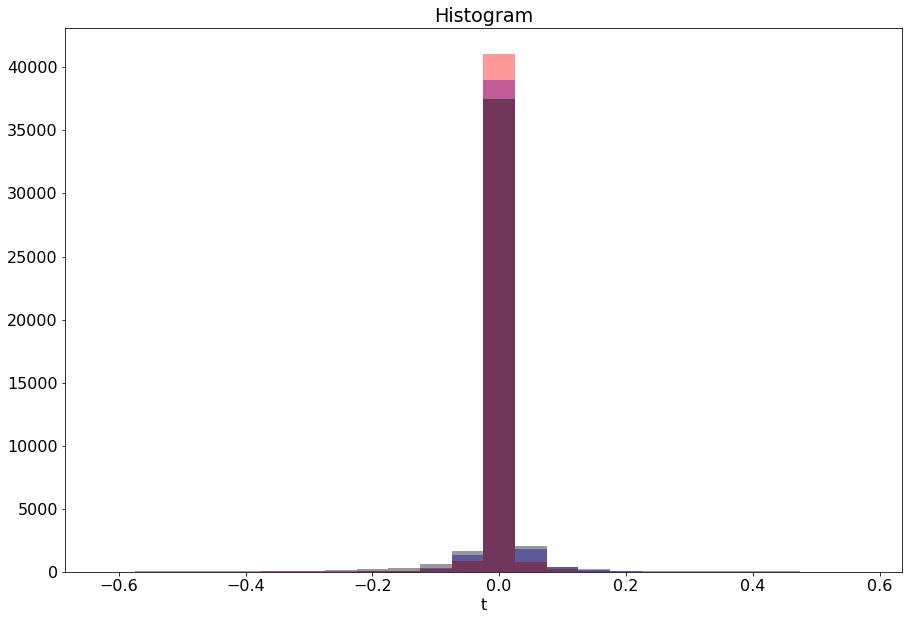

In [6]:
plt.figure()
(dst1.t-dst1.t[:,0]).plot.hist(bins=np.arange(-0.625,0.625,0.05),ls='dashed',lw=3,fc=(0, 0, 1, 0.4))

(dst5.t-dst5.t[:,0]).plot.hist(bins=np.arange(-0.625,0.625,0.05),ls='dotted',lw=3,fc=(1, 0, 0, 0.4))

(dst10.t-dst10.t[:,0]).plot.hist(bins=np.arange(-0.625,0.625,0.05),lw=3,fc=(0, 0, 0, 0.4))


In [2]:
dst = xr.open_dataset('5DayParticles.nc')
dst300 = xr.open_dataset('5Day300Particles.nc')
dst350 = xr.open_dataset('5Day350Particles.nc')

(array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0., 5120.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.]),
 array([-6.25000000e-01, -6.00000000e-01, -5.75000000e-01, -5.50000000e-01,
        -5.25000000e-01, -5.00000000e-01, -4.75000000e-01, -4.50000000e-01,
        -4.25000000e-01, -4.00000000e-01, -3.75000000e-01, -3.50000000e-01,
        -3.25000000e-01, -3.00000000e-01, -2.75000000e-01, -2.50000000e-01,
        -2.25000000e-01, -2.00000000e-01, -1.75000000e-01, -1.50000000e-01,
        -1.25000000e-01, -1.00000000e-01, -7.50000000e-02, -5.00000000e-02,
        -2.50000000e-02,  5.55111512e-16,  2.50000000e-02,  5.00000000e-02,
         7.50000000e-02,  1.00000000e-01,  1.25000000e-01,  1.50000000e-01,

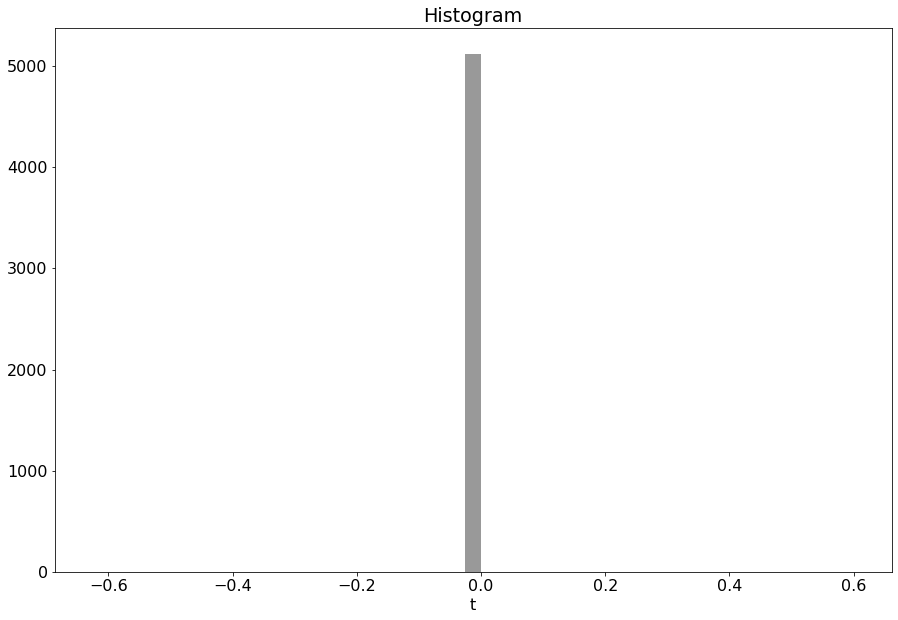

In [8]:
plt.figure()
#(dst.t-dst.t[:,0]).plot.hist(bins=np.arange(-0.625,0.625,0.025),ls='dashed',lw=3,fc=(0, 0, 1, 0.4))

#(dst300.t-dst300.t[:,0]).plot.hist(bins=np.arange(-0.625,0.625,0.025),ls='dotted',lw=3,fc=(1, 0, 0, 0.4))

(dst350.t-dst350.t[:,0]).plot.hist(bins=np.arange(-0.625,0.625,0.025),lw=3,fc=(0, 0, 0, 0.4))